# Testing Model Outputs

In [3]:
import os
import time
import numpy as np 
import torch
import torch.nn as nn
import torchvision
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
import cv2
from torchvision.utils import save_image
from tqdm import tqdm
import matplotlib.pyplot as plt

File[0]: 000000339995.jpg | Total Files: 40670 | Process: test


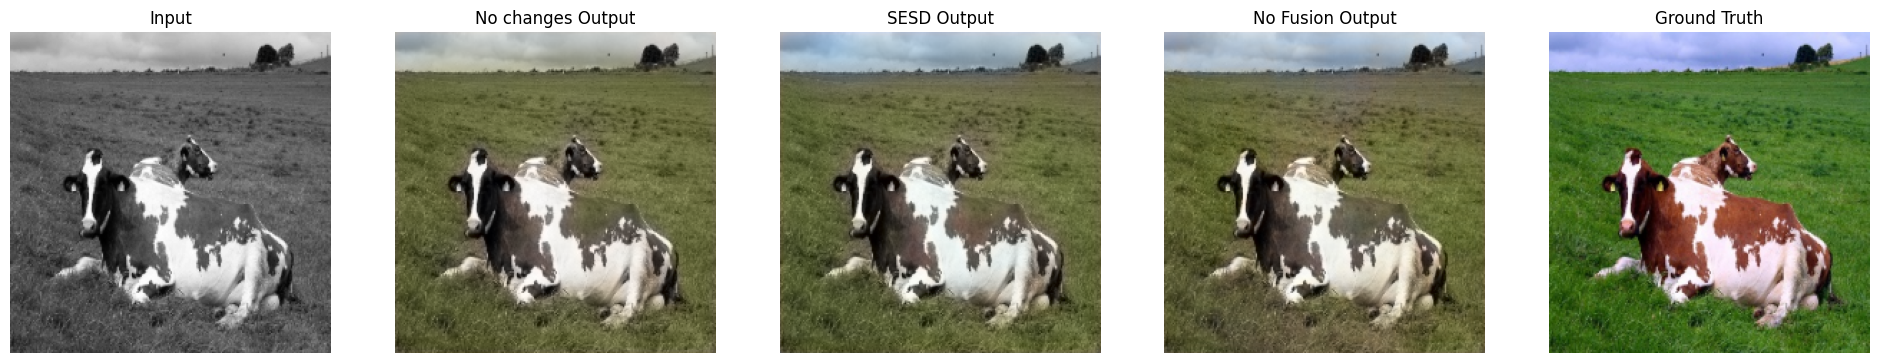

In [7]:
import Trained_Colourization_Models as tcm
import matplotlib.pyplot as plt
import numpy as np

test_dataset = tcm.CustomDataset('coco2017/test2017','test')
ti2 = tcm.Testing_Image(test_dataset, filename='000000000019.jpg')
model_runner = tcm.Default_Model_Runner()
output_img = model_runner.get_image_output(ti2)
model_runner_2 = tcm.SESD_Model_Runner()
output_img_2 = model_runner_2.get_image_output(ti2)
model_runner_3 = tcm.NoFusion_Model_Runner()
output_img_3 = model_runner_3.get_image_output(ti2)

fig, ax = plt.subplots(1, 5, figsize=(24, 12))

ax[0].imshow(ti2.get_gray(), cmap='gray')
ax[0].set_title('Input')
ax[1].imshow(output_img)
ax[1].set_title('No changes Output')
ax[2].imshow(output_img_2)
ax[2].set_title('SESD Output')
ax[3].imshow(output_img_3)
ax[3].set_title('No Fusion Output')
ax[4].imshow(ti2.get_rgb())
ax[4].set_title('Ground Truth')

# clear x-axis and y-axis
ax[0].axis('off')
ax[1].axis('off') 
ax[2].axis('off')
ax[3].axis('off')
ax[4].axis('off')

plt.show()

File[0]: 000000339995.jpg | Total Files: 40670 | Process: test


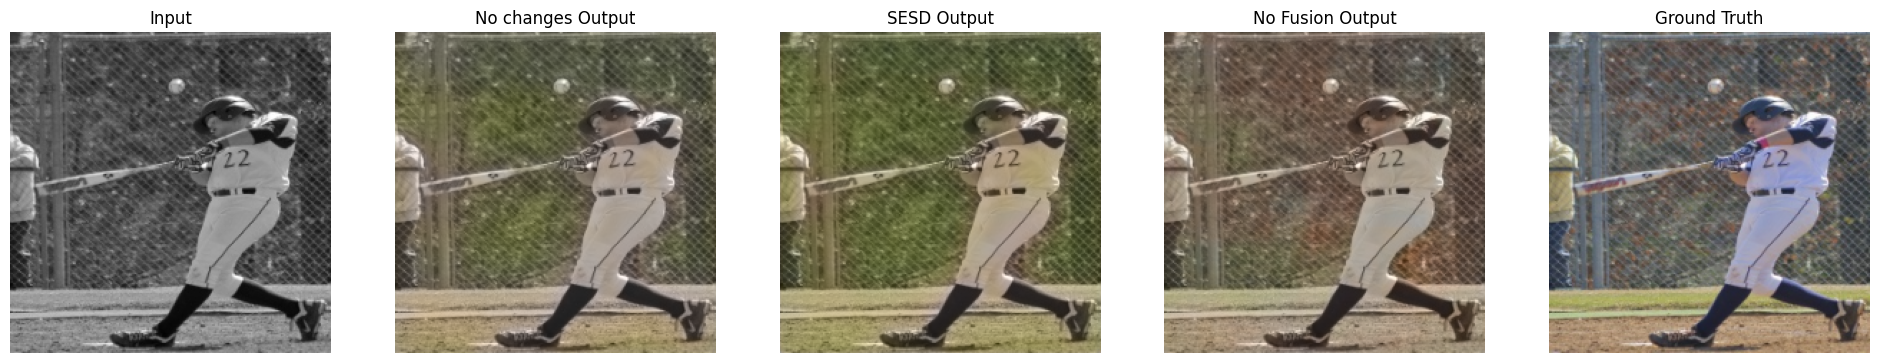

In [5]:
import Trained_Colourization_Models as tcm
import matplotlib.pyplot as plt
import numpy as np

test_dataset = tcm.CustomDataset('coco2017/test2017','test')
ti2 = tcm.Testing_Image(test_dataset, filename='000000000016.jpg')
model_runner = tcm.Default_Model_Runner()
output_img = model_runner.get_image_output(ti2)
model_runner_2 = tcm.SESD_Model_Runner()
output_img_2 = model_runner_2.get_image_output(ti2)
model_runner_3 = tcm.NoFusion_Model_Runner()
output_img_3 = model_runner_3.get_image_output(ti2)

fig, ax = plt.subplots(1, 5, figsize=(24, 12))

ax[0].imshow(ti2.get_gray(), cmap='gray')
ax[0].set_title('Input')
ax[1].imshow(output_img)
ax[1].set_title('No changes Output')
ax[2].imshow(output_img_2)
ax[2].set_title('SESD Output')
ax[3].imshow(output_img_3)
ax[3].set_title('No Fusion Output')
ax[4].imshow(ti2.get_rgb())
ax[4].set_title('Ground Truth')

# clear x-axis and y-axis
ax[0].axis('off')
ax[1].axis('off') 
ax[2].axis('off')
ax[3].axis('off')
ax[4].axis('off')

plt.show()

In [ ]:
import Trained_Colourization_Models as tcm
import matplotlib.pyplot as plt
import numpy as np

test_dataset = tcm.CustomDataset('coco2017/test2017','test')
ti2 = tcm.Testing_Image(test_dataset, filename='000000000108.jpg')
model_runner = tcm.Default_Model_Runner()
output_img = model_runner.get_image_output(ti2)
model_runner_2 = tcm.SESD_Model_Runner()
output_img_2 = model_runner_2.get_image_output(ti2)
model_runner_3 = tcm.NoFusion_Model_Runner()
output_img_3 = model_runner_3.get_image_output(ti2)

fig, ax = plt.subplots(1, 5, figsize=(24, 12))

ax[0].imshow(ti2.get_gray(), cmap='gray')
ax[0].set_title('Input')
ax[1].imshow(output_img)
ax[1].set_title('No changes Output')
ax[2].imshow(output_img_2)
ax[2].set_title('SESD Output')
ax[3].imshow(output_img_3)
ax[3].set_title('No Fusion Output')
ax[4].imshow(ti2.get_rgb())
ax[4].set_title('Ground Truth')

# clear x-axis and y-axis
ax[0].axis('off')
ax[1].axis('off') 
ax[2].axis('off')
ax[3].axis('off')
ax[4].axis('off')

plt.show()